# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math
import time
import os
import numpy as np
import natsort
import csv
import random

# Network Setting

In [2]:
epochSize = 200
batchSize = 2
testSize = 12
valSize = 12
learningRate = 1e-4
momentum = 0.5
printInterval = 10
classSize = 6
classLabel = ['Nine','Ten','Jack','Queen','King','Ace']

torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.set_device(0)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
GeForce GTX 1050


# Time Record

In [3]:
class Timers:
    def __init__(self):
        self.trainTime = 0
        self.testTime = 0
        self.valTime = 0
        self.forwardTime = 0
        self.backwardTime = 0
        self.dataLoadTime = 0
        self.convToBoxTime = 0
        self.BoxToConvTime = 0
        self.yoloLossTime = 0
        self.yoloActTime = 0
        self.noMaxSupTime = 0
        self.printBoxTime = 0

    def printTimelaps(self):
        print("Train Time:",int(self.trainTime)-int(self.valTime)," Test Time:",int(self.testTime)," Val Time:",int(self.valTime)," Forward Time:",int(self.forwardTime)," Backward Time:",int(self.backwardTime),
             "\nData Load Time:",int(self.dataLoadTime)," Conv To Box Time:",int(self.convToBoxTime)," Box To Conv Time:",int(self.BoxToConvTime),
              "\nYolo Loss Time:",int(self.yoloLossTime),"Yolo Activation Time:",int(self.yoloActTime),"Non Max Suppress Time:",int(self.noMaxSupTime),"Print Box Time:",int(self.printBoxTime))

t = Timers()

# Basic Blocks

In [4]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        
        x = x * (torch.tanh(torch.nn.functional.softplus(x)))
        return x

    
class ConvMish(nn.Module):
    def __init__(self,inChannel,outChannel,kernelSize,stride):
        super(ConvMish,self).__init__()
        
        pad = (kernelSize - 1) // 2
        
        self.conv = nn.Conv2d(inChannel,outChannel,kernel_size=kernelSize, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(outChannel)
        self.mish = Mish()
        
    def forward(self,x):
        
        out = self.conv(x)
        out = self.bn(out)
        out = self.mish(out)
        
        return out
    
    
class ConvLeaky(nn.Module):
    def __init__(self,inChannel,outChannel,kernelSize,stride):
        super(ConvLeaky,self).__init__()
        
        pad = (kernelSize - 1) // 2
        
        self.conv = nn.Conv2d(inChannel,outChannel,kernel_size=kernelSize, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(outChannel)
        self.leaky = nn.LeakyReLU()
        
    def forward(self,x):
        
        out = self.conv(x)
        out = self.bn(out)
        out = self.leaky(out)
        
        return out

# Backbone Model

In [5]:
class ResBlock(nn.Module):
    def __init__(self,channel,numBlock):
        super(ResBlock,self).__init__()
        
        self.ConvMish1 = ConvMish(channel,channel,1,1)
        self.ConvMish2 = ConvMish(channel,channel,3,1)
        
        self.moduleList = nn.ModuleList()
        for i in range(numBlock):
            singleResBlock = nn.ModuleList()
            singleResBlock.append(ConvMish(channel,channel,1,1))
            singleResBlock.append(ConvMish(channel,channel,3,1))
            self.moduleList.append(singleResBlock)
        
    def forward(self,x):
        out = x
        for res in self.moduleList:
            temp = out
            for layer in res:
                temp = layer(temp)
        
            out = out+temp
        
        return out
    
    
class CSPBlock(nn.Module):
    def __init__(self,inChannel,outChannel,numRes):
        super(CSPBlock,self).__init__()
        
        self.convMish1 = ConvMish(inChannel,outChannel,3,2)
        self.convMish2 = ConvMish(outChannel,inChannel,1,1)
        self.convMish3 = ConvMish(outChannel,inChannel,1,1)
        self.convMish4 = ConvMish(inChannel,inChannel,1,1)
        self.convMish5 = ConvMish(outChannel,outChannel,1,1)
        
        self.res = ResBlock(inChannel,numRes)
        
        
    def forward(self,x):
        
        out = self.convMish1(x)
        
        out1 = self.convMish2(out)
        
        out2 = self.convMish3(out)
        out2 = self.res(out2)
        out2 = self.convMish4(out2)
        
        out = torch.cat([out1, out2], dim=1)
        out = self.convMish5(out)
        
        return out

class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet,self).__init__()
        
        self.convMish = ConvMish(3,32,3,1)
        self.csp1 = CSPBlock(32,64,1)
        self.csp2 = CSPBlock(64,128,2)
        self.csp3 = CSPBlock(128,256,8)
        self.csp4 = CSPBlock(256,512,8)
        self.csp5 = CSPBlock(512,1024,4)
        
    def forward(self,x):
        
        out = self.convMish(x)
        out = self.csp1(out)
        out = self.csp2(out)
        out3 = self.csp3(out)
        out4 = self.csp4(out3)
        out5 = self.csp5(out4)
        
        return out3,out4,out5

# Neck Model

In [6]:
class SPP(nn.Module):
    def __init__(self):
        super(SPP,self).__init__()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size = 5,stride = 1, padding = 5//2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 9, stride = 1, padding = 9//2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 13, stride = 1, padding = 13//2)
        
        self.convLeaky1 = ConvLeaky(1024,512,1,1)
        self.convLeaky2 = ConvLeaky(512,1024,3,1)
        self.convLeaky3 = ConvLeaky(1024,512,1,1)
        
        self.convLeaky4 = ConvLeaky(2048,512,1,1)
        self.convLeaky5 = ConvLeaky(512,1024,3,1)
        self.convLeaky6 = ConvLeaky(1024,512,1,1)
        
    def forward(self,x):
        
        out = self.convLeaky1(x)
        out = self.convLeaky2(out)
        out = self.convLeaky3(out)
        
        p1 = self.maxpool1(out)
        p2 = self.maxpool2(out)
        p3 = self.maxpool3(out)      
        out = torch.cat([p3, p2, p1, out], dim=1)
        
        out = self.convLeaky4(out)
        out = self.convLeaky5(out)
        out = self.convLeaky6(out)
        
        return out
    
    
class UpSampling(nn.Module):
    def __init__(self):
        super(UpSampling,self).__init__()
    
    def forward(self,x,targetSize):
        
        return F.interpolate(x,size=(targetSize[2], targetSize[3]),mode='nearest')   
    
    
class YOLONeck(nn.Module):
    def __init__(self):
        super(YOLONeck,self).__init__()
    
        self.spp = SPP()
        
        self.convLeaky1 = ConvLeaky(512, 256, 1, 1)
        self.upSample1 = UpSampling()
        self.convLeaky2 = ConvLeaky(512, 256, 1, 1)
        
        self.convLeaky3 = ConvLeaky(512, 256, 1, 1)
        self.convLeaky4 = ConvLeaky(256, 512, 3, 1)
        self.convLeaky5 = ConvLeaky(512, 256, 1, 1)
        self.convLeaky6 = ConvLeaky(256, 512, 3, 1)
        self.convLeaky7 = ConvLeaky(512, 256, 1, 1)
        
        self.convLeaky8 = ConvLeaky(256, 128, 1, 1)
        self.upSample2 = UpSampling()
        self.convLeaky9 = ConvLeaky(256, 128, 1, 1)
        
        self.convLeaky10 = ConvLeaky(256, 128, 1, 1)
        self.convLeaky11 = ConvLeaky(128, 256, 3, 1)
        self.convLeaky12 = ConvLeaky(256, 128, 1, 1)
        self.convLeaky13 = ConvLeaky(128, 256, 3, 1)
        self.convLeaky14 = ConvLeaky(256, 128, 1, 1)
    
    def forward(self, csp3, csp4,csp5):
        
        out1 = self.spp(csp5)
        
        out2a = self.convLeaky1(out1)
        out2a = self.upSample1(out2a,csp4.size())
        out2b = self.convLeaky2(csp4)
        out2 = torch.cat([out2a, out2b], dim=1)
        
        out2 = self.convLeaky3(out2)
        out2 = self.convLeaky4(out2)
        out2 = self.convLeaky5(out2)
        out2 = self.convLeaky6(out2)
        out2 = self.convLeaky7(out2)
        
        out3a = self.convLeaky8(out2)
        out3a = self.upSample2(out3a,csp3.size())
        out3b = self.convLeaky9(csp3)
        out3 = torch.cat([out3a, out3b], dim=1)
        
        out3 = self.convLeaky10(out3)
        out3 = self.convLeaky11(out3)
        out3 = self.convLeaky12(out3)
        out3 = self.convLeaky13(out3)
        out3 = self.convLeaky14(out3)
        
        return out1,out2,out3
    

# YOLO Head Model

In [7]:
class YOLOHead(nn.Module):
    def __init__(self,outChannel,numAnchor):
        super(YOLOHead,self).__init__()
        
        self.convLeaky1 = ConvLeaky(128, 256, 3, 1)
        self.convOut1 = nn.Conv2d(256,outChannel,kernel_size=1)
        
        self.convLeaky2= ConvLeaky(128, 256, 3, 2)
        
        self.convLeaky3 = ConvLeaky(512, 256, 1, 1)
        self.convLeaky4 = ConvLeaky(256, 512, 3, 1)
        self.convLeaky5 = ConvLeaky(512, 256, 1, 1)
        self.convLeaky6 = ConvLeaky(256, 512, 3, 1)
        self.convLeaky7 = ConvLeaky(512, 256, 1, 1)
        
        self.convLeaky8 = ConvLeaky(256, 512, 3, 1)
        self.convOut2 = nn.Conv2d(512,outChannel,kernel_size=1)
        
        self.convLeaky9 = ConvLeaky(256, 512, 3, 2)
        
        self.convLeaky10 = ConvLeaky(1024, 512, 1, 1)
        self.convLeaky11 = ConvLeaky(512, 1024, 3, 1)
        self.convLeaky12 = ConvLeaky(1024, 512, 1, 1)
        self.convLeaky13 = ConvLeaky(512, 1024, 3, 1)
        self.convLeaky14 = ConvLeaky(1024, 512, 1, 1)
        
        self.convLeaky15 = ConvLeaky(512, 1024, 3, 1)
        self.convOut3 = nn.Conv2d(1024,outChannel,kernel_size=1)
        
    
    def forward(self,x1,x2,x3):
        
        out1 = self.convLeaky1(x3)
        out1 = self.convOut1(out1)
        
        temp1 = self.convLeaky2(x3)
        temp1 = torch.cat([temp1, x2], dim=1)
        
        temp1 = self.convLeaky3(temp1)
        temp1 = self.convLeaky4(temp1)
        temp1 = self.convLeaky5(temp1)
        temp1 = self.convLeaky6(temp1)
        temp1 = self.convLeaky7(temp1)
        
        out2 = self.convLeaky8(temp1)
        out2 = self.convOut2(out2)
        
        temp2 = self.convLeaky9(temp1)
        temp2 = torch.cat([temp2, x1], dim=1)
        
        temp2 = self.convLeaky10(temp2)
        temp2 = self.convLeaky11(temp2)
        temp2 = self.convLeaky12(temp2)
        temp2 = self.convLeaky13(temp2)
        temp2 = self.convLeaky14(temp2)
        
        out3 = self.convLeaky15(temp2)
        out3 = self.convOut3(out3)
                                   
        return out1,out2,out3
    
    
class YOLONet(nn.Module):
    def __init__(self,numClass,numAnchor):
        super(YOLONet,self).__init__()
    
        outChannel = (4 + 1 + numClass) * numAnchor
        
        self.backbone = DenseNet()
        self.neck = YOLONeck()
        self.head = YOLOHead(outChannel,numAnchor)
    
    def forward(self,x):
        
        out1,out2,out3 = self.backbone(x)
        out1,out2,out3 = self.neck(out1,out2,out3)
        out1,out2,out3 = self.head(out1,out2,out3)
        
        return out1,out2,out3

# YOLO Interface

In [8]:
class Anchor:
    def __init__(self,anchorW,anchorH,hIdx,wIdx,sIdx,rIdx,cellW):
        self.cellW = cellW
        
        self.x_ctr = cellW/2+wIdx*cellW
        self.y_ctr = cellW/2+hIdx*cellW
        
        self.width = anchorW
        self.height = anchorH
        
        self.wIdx = wIdx
        self.hIdx = hIdx
        self.sIdx = sIdx
        self.rIdx = rIdx
        
        self.x_min = self.x_ctr-anchorW/2
        self.y_min = self.y_ctr-anchorH/2
        self.x_max = self.x_ctr+anchorW/2
        self.y_max = self.y_ctr+anchorH/2
        
    def getBox(self):
        return np.array([self.x_min , self.y_min , self.x_max , self.y_max])
    
    def printBox(self):
        print("X min:",self.x_min,"Y min:",self.y_min,"X max:",self.x_max,"Y max:",self.y_max)
        
class ObjBox:
    def __init__(self,x_bias,y_bias,h_bias,w_bias,cls,conf,anchor):
        
        self.x_ctr = anchor.x_ctr+(x_bias-0.5)*anchor.cellW
        self.y_ctr = anchor.y_ctr+(y_bias-0.5)*anchor.cellW
        
        self.width = anchor.cellW*w_bias
        self.height = anchor.cellW*h_bias
        
        self.x_min = self.x_ctr-self.width/2
        self.y_min = self.y_ctr-self.height/2
        self.x_max = self.x_ctr+self.width/2
        self.y_max = self.y_ctr+self.height/2
        
        self.cls = cls
        self.conf = conf
        
    def getBox(self):
        return np.array([self.x_min , self.y_min , self.x_max , self.y_max])
    
    def printBox(self):
        print("X min:",self.x_min,"Y min:",self.y_min,"X max:",self.x_max,"Y max:",self.y_max)
        
class YOLOInterface:
    def __init__(self,outputSize):
        self.anchorSize = [0.05,0.1,0.25]
        self.anchorRatio = [0.66,1,1.66]
        self.anchorNum = 6
        
        self.outputSize = outputSize
        
        self.anchorW = np.zeros((len(self.anchorSize),len(self.anchorRatio))) # 3x3
        self.anchorH = np.zeros((len(self.anchorSize),len(self.anchorRatio))) # 3x3
        self.gridCellWidth = [1.0/outputSize[0][2], 1.0/outputSize[1][2], 1.0/outputSize[2][2]]
        
        self.fittedAnchorArr = []

        self.ObjectLoss = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([200]), reduction='sum').cuda() #1970pos_weight = torch.tensor([1970]),
        self.ClassLoss = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([200]), reduction='sum').cuda() #11850pos_weight = torch.tensor([11850]),
        
        
        for i in range(len(self.anchorSize)):
            for j in range(len(self.anchorRatio)):
                self.anchorW[i,j] = self.anchorSize[i]*self.anchorRatio[j]
                self.anchorH[i,j] = self.anchorSize[i]/self.anchorRatio[j]
            
    def IOU(self,ach,obj):
        # ~~~~ Calculate IOU ~~~~
        iou = 0
        
        xA = max(ach[0], obj[0])
        yA = max(ach[1], obj[1])
        xB = min(ach[2], obj[2])
        yB = min(ach[3], obj[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        
        achArea = (ach[2] - ach[0]) * (ach[3] - ach[1])
        objArea = (obj[2] - obj[0]) * (obj[3] - obj[1])
        
        iou = interArea / float(achArea + objArea - interArea)
        return iou
    
    # ~~~ For all output mtx and mtx slices, obtain anchor details with box dimension bias then store anchor obj ~~~ #
    def convOutputToBox(self,yoloAns1,yoloAns2,yoloAns3):
        convToBoxStartTime = time.time()
        objBoxArr = []
        matchAnchorArr = []
        yoloAnsArr = [yoloAns1,yoloAns2,yoloAns3]
        maxArr = []
        clsMaxArr = []
        classDtbArr = np.array([0,0,0,0,0,0])
        loopIdx = 0
        confidenceLevel = 0.95
        
        for sIdx in range(len(self.anchorSize)): # in range of (3)
            yoloAns = yoloAnsArr[sIdx]
            
            for rIdx in range(len(self.anchorRatio)): # in range of (3)
                
                sliceIdx = rIdx*(5+classSize)
                
                isObjMtx = yoloAns[sliceIdx,:,:] # The first slice of output of [5+class Num]
                classMtx = yoloAns[sliceIdx+5:sliceIdx+11,:,:]
                
                objPosArr = np.where(isObjMtx > confidenceLevel)
                objPosArr = np.array(objPosArr)
                
                maxArr.append(np.amax(np.array(isObjMtx)))
                clsMaxArr.append(np.amax(np.array(classMtx)))
                # --- objPosArr = [[All hIdx],[All wIdx]] , shape = [2,obj amount] ---
                
                for objIdx in range(objPosArr.shape[1]): # in range of (amount of object matched in current anchor ratio & size)
                    hIdx = objPosArr[0][objIdx]
                    wIdx = objPosArr[1][objIdx]

                    # ~~~ Determin matched anchor ~~~ #
                    fitAnchor = Anchor(self.anchorW[sIdx,rIdx],self.anchorH[sIdx,rIdx],hIdx,wIdx,sIdx,rIdx,self.gridCellWidth[sIdx])
                    matchAnchorArr.append(fitAnchor)

                    # ~~~ Determine four corner of object box ~~~ #
                    sliceIdx = rIdx*(5+classSize)
                    x_bias = yoloAns[sliceIdx+1,hIdx,wIdx]
                    y_bias = yoloAns[sliceIdx+2,hIdx,wIdx]
                    h_bias = yoloAns[sliceIdx+3,hIdx,wIdx]
                    w_bias = yoloAns[sliceIdx+4,hIdx,wIdx]
                    clsArr = np.array(yoloAns[sliceIdx+5:sliceIdx+11,hIdx,wIdx])
                    cls = np.argmax(clsArr)
                    objBoxArr.append(ObjBox(x_bias,y_bias,h_bias,w_bias,cls,isObjMtx[hIdx,wIdx],fitAnchor))
                    
                    classDtbArr = np.add(classDtbArr,clsArr)
                    loopIdx = loopIdx+1
        t.convToBoxTime += time.time()-convToBoxStartTime
        
        return matchAnchorArr,objBoxArr

    # ~~~ Assign object to cloest anchor, calculate IOU between anchors and every object, store anchor with max IOU ~~~ #
    def dataToYOLOConv(self,objBoxes):
        # --- objBoxes shape = [objects amount,class amount + xy min max] ---
        # --- outputSize = [CxHxW] ---
        BoxToConvStartTime = time.time()
        yoloAns1 = np.zeros((self.outputSize[0][0],self.outputSize[0][1],self.outputSize[0][2])) #[CxHxW]
        yoloAns2 = np.zeros((self.outputSize[1][0],self.outputSize[1][1],self.outputSize[1][2])) #[CxHxW]
        yoloAns3 = np.zeros((self.outputSize[2][0],self.outputSize[2][1],self.outputSize[2][2])) #[CxHxW]
        
        for objIdx in range(objBoxes.shape[0]): # in range of amount of object in image
            maxIOU = 0
            fittedAnchor = 0
            obj_x_ctr = (objBoxes[objIdx,6]+objBoxes[objIdx,8])/2
            obj_y_ctr = (objBoxes[objIdx,7]+objBoxes[objIdx,9])/2
            obj_h = objBoxes[objIdx,9]-objBoxes[objIdx,7]
            obj_w = objBoxes[objIdx,8]-objBoxes[objIdx,6]
            
            for sIdx in range(len(self.anchorSize)): # in range of (3)
                gridCellWidth = self.gridCellWidth[sIdx]

                hIdx = math.floor(obj_y_ctr/gridCellWidth)
                wIdx = math.floor(obj_x_ctr/gridCellWidth)
                
                for rIdx in range(len(self.anchorRatio)): # in range of (3)

                    currentAnchor = Anchor(self.anchorW[sIdx,rIdx],self.anchorH[sIdx,rIdx],hIdx,wIdx,sIdx,rIdx,gridCellWidth)

                    iou = self.IOU(currentAnchor.getBox(),objBoxes[objIdx,6:10])
                    
                    if iou > maxIOU:
                        maxIOU = iou
                        fittedAnchor = currentAnchor
            
            # ~~~~ Change the yoloAns value ~~~~
            if fittedAnchor == 0:
                print(objBoxes)
                
            hIdx = fittedAnchor.hIdx
            wIdx = fittedAnchor.wIdx
            rIdx = fittedAnchor.rIdx
            sIdx = fittedAnchor.sIdx
            cIdx = rIdx*(5+classSize)            
            gridCellWidth = self.gridCellWidth[sIdx]
            
            if sIdx == 0:
                yoloAns1[cIdx,hIdx,wIdx] = 1.0
                yoloAns1[cIdx+1,hIdx,wIdx] = (obj_x_ctr-gridCellWidth*wIdx)/gridCellWidth
                yoloAns1[cIdx+2,hIdx,wIdx] = (obj_y_ctr-gridCellWidth*hIdx)/gridCellWidth
                yoloAns1[cIdx+3,hIdx,wIdx] = obj_h/gridCellWidth
                yoloAns1[cIdx+4,hIdx,wIdx] = obj_w/gridCellWidth
                yoloAns1[cIdx+5:cIdx+11,hIdx,wIdx] = objBoxes[objIdx,0:6]
            elif sIdx == 1:
                yoloAns2[cIdx,hIdx,wIdx] = 1.0
                yoloAns2[cIdx+1,hIdx,wIdx] = (obj_x_ctr-gridCellWidth*wIdx)/gridCellWidth
                yoloAns2[cIdx+2,hIdx,wIdx] = (obj_y_ctr-gridCellWidth*hIdx)/gridCellWidth
                yoloAns2[cIdx+3,hIdx,wIdx] = obj_h/gridCellWidth
                yoloAns2[cIdx+4,hIdx,wIdx] = obj_w/gridCellWidth
                yoloAns2[cIdx+5:cIdx+11,hIdx,wIdx] = objBoxes[objIdx,0:6]
            elif sIdx == 2:
                yoloAns3[cIdx,hIdx,wIdx] = 1.0
                yoloAns3[cIdx+1,hIdx,wIdx] = (obj_x_ctr-gridCellWidth*wIdx)/gridCellWidth
                yoloAns3[cIdx+2,hIdx,wIdx] = (obj_y_ctr-gridCellWidth*hIdx)/gridCellWidth
                yoloAns3[cIdx+3,hIdx,wIdx] = obj_h/gridCellWidth
                yoloAns3[cIdx+4,hIdx,wIdx] = obj_w/gridCellWidth
                yoloAns3[cIdx+5:cIdx+11,hIdx,wIdx] = objBoxes[objIdx,0:6]
            
            self.fittedAnchorArr.append(fittedAnchor)
            
        t.BoxToConvTime += time.time()-BoxToConvStartTime
        
        return yoloAns1,yoloAns2,yoloAns3
    
    def yoloLoss(self,output1,output2,output3,yoloAns1,yoloAns2,yoloAns3):
        # --- outputn shape = yoloAnsn shape = [B,C,H,W] ---
        yoloLossStartTime = time.time()
        obj_loss = 0
        xy_loss = 0
        wh_loss = 0
        class_loss = 0
        
        outputArr = [output1,output2,output3]
        yoloAnsArr = [yoloAns1,yoloAns2,yoloAns3]
        
        for sIdx in range(len(self.anchorSize)): # in range of output conv amount (3)
            
            output = outputArr[sIdx]
            output_mask = torch.zeros(output.size()).to(device)
            yoloAns = yoloAnsArr[sIdx].type('torch.cuda.FloatTensor')
            
            for rIdx in range(len(self.anchorRatio)): # in range of (3)
                sliceIdx = rIdx*(5+classSize)
                
                # ~~~~ Split Convolution channel ~~~~
                obj_ans = yoloAns[:,sliceIdx,:,:]
                xy_ans = yoloAns[:,sliceIdx+1:sliceIdx+3,:,:]
                wh_ans = yoloAns[:,sliceIdx+3:sliceIdx+5,:,:]
                class_ans = yoloAns[:,sliceIdx+5:sliceIdx+11,:,:]
                
                # ~~~~ Define mask ~~~~
                mask = obj_ans 
                xywh_mask = torch.zeros(output.size()[0],2,output.size()[2],output.size()[3]).to(device)
                class_mask = torch.zeros(output.size()[0],classSize,output.size()[2],output.size()[3]).to(device)
                xywh_mask[:,0,:,:] = mask
                xywh_mask[:,1,:,:] = mask
                for mIdx in range(classSize):
                    class_mask[:,mIdx,:,:] = mask
                
                # ~~~~ Mask the Convlution output ~~~~
                obj_output = output[:,sliceIdx,:,:]
                xy_output = output[:,sliceIdx+1:sliceIdx+3,:,:]*xywh_mask
                wh_output = output[:,sliceIdx+3:sliceIdx+5,:,:]*xywh_mask
                class_output = output[:,sliceIdx+5:sliceIdx+11,:,:]#*class_mask
                
                # ~~~~ Calculate Loss ~~~~
                obj_loss += self.ObjectLoss(obj_output,obj_ans)
                xy_loss += F.mse_loss(xy_output,xy_ans, reduction='sum')*100
                wh_loss += F.mse_loss(wh_output,wh_ans, reduction='sum')*1000
                class_loss += self.ClassLoss(class_output,class_ans)
        
        loss = obj_loss + xy_loss + wh_loss + class_loss
        lossArr = [obj_loss,xy_loss,wh_loss,class_loss]
        
        t.yoloLossTime += time.time() - yoloLossStartTime
        return loss,lossArr
    
    def yoloActivation(self,output1,output2,output3):
        yoloActStartTime = time.time()
        outputArr = [output1,output2,output3]
        
        for sIdx in range(len(self.anchorSize)):
            output = outputArr[sIdx]
            
            for rIdx in range(len(self.anchorRatio)):
                sliceIdx = rIdx*(5+classSize)            
                output[:,sliceIdx,:,:] = F.sigmoid(output[:,sliceIdx,:,:])
                output[:,sliceIdx+5:sliceIdx+11,:,:] = F.sigmoid(output[:,sliceIdx+5:sliceIdx+11,:,:])
        
        t.yoloActTime += time.time()-yoloActStartTime

        return outputArr[0],outputArr[1],outputArr[2]
    
    def nonMaxSuppresion(self,anchorArr,objBoxArr):
        noMaxSupStartTime = time.time()
        maxBoxArr = []
        maxAnchorArr = []
        isMaxArr = np.zeros(len(objBoxArr))
        confidenceLevel = 0.5
        itr = 0
        
        while len(objBoxArr) > 0:
            
            # ~~~~ Find max confidence and save it ~~~~          
            maxIdx = 0
            maxObj = objBoxArr[0]
            maxAnc = anchorArr[0]
            for i in range(len(objBoxArr)):
                if objBoxArr[i].conf > maxObj.conf:
                    maxObj = objBoxArr[i]
                    maxAnc = anchorArr[i]
                    maxIdx = i
            maxBoxArr.append(maxObj)
            maxAnchorArr.append(maxAnc)
            
            # ~~~~ Find overlapped box and record in array ~~~~
            overlapIdxArr = []
            for i in range(len(objBoxArr)):
                if objBoxArr[i].cls == maxObj.cls and i != maxIdx and self.IOU(maxObj.getBox(),objBoxArr[i].getBox()) > confidenceLevel: #
                    overlapIdxArr.append(i)
            
            # ~~~~ Delete overlapped box and also max confidence object from array ~~~~
            arrLength = len(overlapIdxArr)
            for i in range(len(overlapIdxArr)-1,-1,-1):
                objBoxArr.remove(objBoxArr[overlapIdxArr[i]])
                anchorArr.remove(anchorArr[overlapIdxArr[i]])

            objBoxArr.remove(maxObj)
            anchorArr.remove(maxAnc)
            
            itr = itr+1
        
        t.noMaxSupTime += time.time()-noMaxSupStartTime
        return maxAnchorArr,maxBoxArr
    
    def printBox(self,imgIdx,image,anchorArr,objBoxArr,ansBoxArr = []):
        printBoxStartTime = time.time()
        ax = plt.subplot(4,3,imgIdx+1)
        ax.imshow(np.transpose(image[imgIdx].cpu(), (1, 2, 0)))
        clsCount = np.zeros(classSize)
        ansCount = np.zeros(classSize)
        classColour = ['red','orange','yellow','lime','blue','magenta']

        for j in range(len(anchorArr)):
            # ~~~~ Plot Anchor ~~~~
            x_min = anchorArr[j].x_min*imgLength
            y_min = anchorArr[j].y_min*imgLength
            w = anchorArr[j].width*imgLength
            h = anchorArr[j].height*imgLength
            #ax.add_patch(patches.Rectangle((x_min,y_min),w,h,linewidth=1,edgecolor='r',facecolor='none'))
            #plt.plot(anchorArr[j].x_ctr*imgLength, anchorArr[j].y_ctr*imgLength, marker='o', markersize=3, color="red")

            # ~~~~ Plot Object ~~~~
            x_min = objBoxArr[j].x_min*imgLength
            y_min = objBoxArr[j].y_min*imgLength
            w = objBoxArr[j].width*imgLength
            h = objBoxArr[j].height*imgLength
            cls = objBoxArr[j].cls
            ax.add_patch(patches.Rectangle((x_min,y_min),w,h,linewidth=1,edgecolor=classColour[cls],facecolor='none'))
            #plt.plot(objBoxArr[j].x_ctr*imgLength, objBoxArr[j].y_ctr*imgLength, marker='o', markersize=3, color="blue")

            clsCount[cls] = clsCount[cls]+1

        
        for i in range(len(ansBoxArr)):
            ans = ansBoxArr[i].cls
            ansCount[ans] = ansCount[ans]+1
            
        ansCount = ansCount.astype(int)
        clsCount = clsCount.astype(int)
        
        ax.title.set_text(
            'Nine:'+str(clsCount[0])+'/'+str(ansCount[0])+' Ten:'+str(clsCount[1])+'/'+str(ansCount[1])
            +' Jack:'+str(clsCount[2])+'/'+str(ansCount[2])+' Queen:'+str(clsCount[3])+'/'+str(ansCount[3])
            +' King:'+str(clsCount[4])+'/'+str(ansCount[4])+' Ace:'+str(clsCount[5])+'/'+str(ansCount[5]))

        plt.xticks([])
        plt.yticks([])
        t.printBoxTime += time.time()-printBoxStartTime
        return 0
    
yoloInterface = YOLOInterface([[33,52,52],[33,26,26],[33,13,13]])

# Create Network

In [9]:
network = YOLONet(6,3).to(device)
#network.load_state_dict(torch.load("C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch Pet\\weights161120.pth"))

optimizer = optim.Adam(network.parameters(), weight_decay=0.001,lr=learningRate)
scheduler = ReduceLROnPlateau(optimizer,verbose=True,patience=10,min_lr=1e-7,factor=0.1)

print('Memory Usage:')
print('Allocated:', torch.cuda.memory_allocated(0)/1024/1024, 'MB')
print('Cached:   ', torch.cuda.memory_allocated(0)/1024/1024, 'MB')

pytorch_total_params = sum(p.numel() for p in network.parameters())
print("\nTotal Parameters:",pytorch_total_params)

Memory Usage:
Allocated: 258.74609375 MB
Cached:    258.74609375 MB

Total Parameters: 67473667


# Data Augmentation

In [10]:
import numbers
inputSize = 416
    
HLSAugumentation = transforms.ColorJitter(brightness=[0.5,1.2], contrast=[0.7,1.2], saturation=[0.5,1.5])

initAugumentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((inputSize,inputSize))
])

def translation(img,output,size):
    newImg = torch.ones([3,size,size])
    newImg_ = torch.ones([3,size,size])
    
    w_bias = random.uniform(-0.3, 0.3)
    h_bias = random.uniform(-0.3, 0.3)
    
    w_shift = abs(int(w_bias*size))
    h_shift = abs(int(h_bias*size))
    
    if w_bias > 0:
        newImg[:,:,w_shift:size] = img[:,:,0:(size-w_shift)]
    elif w_bias < 0:
        newImg[:,:,0:(size-w_shift)] = img[:,:,w_shift:size]
        
    if h_bias > 0:
        newImg_[:,h_shift:size,:] = newImg[:,0:(size-h_shift),:]
    elif h_bias < 0:
        newImg_[:,0:(size-h_shift),:] = newImg[:,h_shift:size,:]
    
    deleteIdxArr = []
    for objIdx in range(output.shape[0]):
        output[objIdx,6] = max(output[objIdx,6] + w_bias,0)
        output[objIdx,7] = max(output[objIdx,7] + h_bias,0)
        output[objIdx,8] = min(output[objIdx,8] + w_bias,1)
        output[objIdx,9] = min(output[objIdx,9] + h_bias,1)
        
        if (output[objIdx,6] >= 1) or (output[objIdx,8] <= 0) or (output[objIdx,7] >= 1) or (output[objIdx,9] <= 0):
            deleteIdxArr.append(objIdx)
            
    for i in range(len(deleteIdxArr)-1,-1,-1):
        output = np.delete(output, deleteIdxArr[i], axis=0)
        
    return newImg_,output

def randomWhiteCover(img,size,amount = 1,s_range = [0.15,0.35],r_range = [0.7,1.5]):
        
    for i in range(amount):
        if (random.uniform(0,1) > 0.5):
            s = random.uniform(s_range[0], s_range[1])
            r = random.uniform(r_range[0], r_range[1])
            
            w = s*r
            h = s/r

            x_ctr = random.uniform(0,1)
            y_ctr = random.uniform(0,1)

            x_min = int(max(0,x_ctr-w/2)*size)
            y_min = int(max(0,y_ctr-h/2)*size)
            x_max = int(min(1,x_ctr+w/2)*size)
            y_max = int(min(1,y_ctr+h/2)*size)

            img[:,y_min:y_max,x_min:x_max] = random.uniform(0.85,1)
    
    return img

# Data Set

In [11]:
dataDir = "C://Users//jason//OneDrive//圖片//Machine Learning Data//Card Detection//"
trainDir = os.path.join(dataDir,'train//')
valDir = os.path.join(dataDir,'val//')
testDir = os.path.join(dataDir,'test//')

trainLabelDir = os.path.join(dataDir,"train_labels.csv")
testLabelDir = os.path.join(dataDir,'test_labels.csv')

class CardDetectionDataset(Dataset):

    def __init__(self, csv_file, root_dir, isTrain = False):
        
        self.data = []
        self.root_dir = root_dir
        #self.transform = transform
        self.files = os.listdir(root_dir)
        self.isTrain = isTrain
        
        with open(csv_file, newline='') as f:
            reader = csv.reader(f)
            self.data = list(reader)
        
        self.data = np.array(self.data)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        dataLoadStartTime = time.time()
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.files[idx])
        image = Image.open(img_name)

        result = np.array(np.where(self.data[:,0] == self.files[idx]))
        labelArr = np.array(['nine','ten','jack','queen','king','ace'])
        
        output = np.empty((0,classSize+4), float)
        
        for i in range(result.size):
            output = np.append(output, np.zeros((1,classSize+4)), axis=0)
            
            imageW = float(self.data[result[0,i],1])
            imageH = float(self.data[result[0,i],2])
            
            output[i,6] = float(self.data[result[0,i],4])/imageW # x_min norm
            output[i,7] = float(self.data[result[0,i],5])/imageH # y_min norm
            output[i,8] = float(self.data[result[0,i],6])/imageW # x_max norm
            output[i,9] = float(self.data[result[0,i],7])/imageH # y_max norm
            
            label = self.data[result[0,i],3]
            classIdx = np.where(labelArr == label)
            output[i,classIdx[0]] = 1.0
        
        #if self.transform:
        image = initAugumentation(image)
        if self.isTrain:
            image,output = translation(image,output,inputSize)
            image = randomWhiteCover(image,inputSize,amount = 3)
            image = HLSAugumentation(image)
        
        output1,output2,output3 = yoloInterface.dataToYOLOConv(output)

        t.dataLoadTime += time.time()-dataLoadStartTime
        return image,output1,output2,output3
    
trainData = CardDetectionDataset(trainLabelDir,trainDir,isTrain=True)
valData = CardDetectionDataset(testLabelDir,testDir)
testData = CardDetectionDataset(testLabelDir,testDir)

# Data Loader

In [12]:
trainLoader = torch.utils.data.DataLoader(trainData,batch_size = batchSize,shuffle = True)
valLoader = torch.utils.data.DataLoader(valData,batch_size = valSize,shuffle = True)
testLoader = torch.utils.data.DataLoader(testData,batch_size = testSize,shuffle = False)

trainDataSize = len(trainLoader.dataset)
valDataSize = len(valLoader.dataset)
testDataSize = len(testLoader.dataset)

# Check Training Data

Train Time: 0  Test Time: 0  Val Time: 0  Forward Time: 0  Backward Time: 0 
Data Load Time: 1  Conv To Box Time: 0  Box To Conv Time: 0 
Yolo Loss Time: 0 Yolo Activation Time: 0 Non Max Suppress Time: 0 Print Box Time: 0


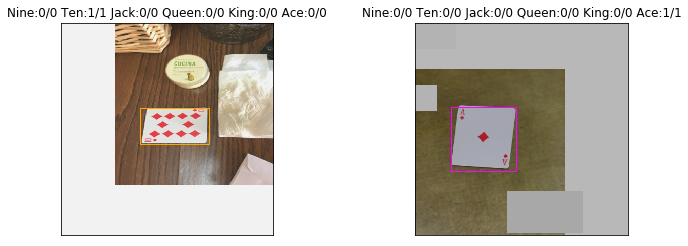

In [13]:
import sys

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)},threshold=sys.maxsize)
examples = enumerate(trainLoader)
batch_idx, (example_data,output1,output2,output3) = next(examples)


imgLength = inputSize
fig = plt.figure(figsize=(18, 18))
for i in range(2):
    anchorArr,objBoxArr = yoloInterface.convOutputToBox(output1[i,:,:,:].cpu(),output2[i,:,:,:].cpu(),output3[i,:,:,:].cpu())
    anchorArr,objBoxArr = yoloInterface.nonMaxSuppresion(anchorArr,objBoxArr)
    yoloInterface.printBox(i,example_data,anchorArr,objBoxArr,objBoxArr)

t.printTimelaps()

# Result Array

In [14]:
trainLossArr = []
trainCounterArr = []
valLossArr = []
valCounterArr = []
testLossArr = []
testCounterArr = [(i+1)*len(trainLoader.dataset) for i in range(epochSize)]

# Training Function

In [15]:
def train(epoch):
    trainStartTime = time.time()
    
    network.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    currentImg = 0
    totalImg = len(trainLoader.dataset)
    
    for idx,(data,label1,label2,label3) in enumerate(trainLoader):
        forwardStartTime = time.time()
        # Put data to GPU
        data = data.to(device)
        label1 = label1.to(device)
        label2 = label2.to(device)
        label3 = label3.to(device)
        
        # Computations
        optimizer.zero_grad()
        output1,output2,output3 = network(data)
        t.forwardTime += time.time() -forwardStartTime
        
        loss,lossArr = yoloInterface.yoloLoss(output1,output2,output3,label1,label2,label3)
        
        backwardStartTime = time.time()
        loss.backward()
        optimizer.step()
        t.backwardTime += time.time() - backwardStartTime
        
        # Calculate acc and loss
        epoch_loss += loss/testDataSize
        
        # Print and record every n interval
        if idx % printInterval == 0:
            
            # Print
            currentImg = idx * len(data)
            epochProgress = currentImg/totalImg
            lossValue = loss.item()
            
            val_loss = val()
            
            if idx == 0:
                print('Train Epoch: {} [{}/{} (0%)]'.format(epoch,idx, len(trainLoader.dataset)))
            else:                
                print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.4f} Val Loss: {:.4f}'.format(
                    epoch,currentImg,totalImg,epochProgress*100 ,lossValue/data.size()[0],val_loss))
            
            # Record
            trainLossArr.append(lossValue)
            trainCounterArr.append(
            (batch_idx*batchSize) + ((epoch-1)*len(trainLoader.dataset)))
            
            valLossArr.append(val_loss)
            valCounterArr.append(
            (batch_idx*batchSize) + ((epoch-1)*len(trainLoader.dataset)))
       
    # Final print
    print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.4f}'.format(epoch,totalImg,totalImg,100 ,loss.item()/data.size()[0]))
    
    t.trainTime += time.time()-trainStartTime

# Testing Function

In [16]:
def test(itr):
    testStartTime = time.time()
    
    network.eval()
    test_loss = 0
    test_lossArr = np.zeros(4)
    test_accuracy = 0
    idx = 0
    printInterval = 10
    
    with torch.no_grad():
        for data,label1,label2,label3 in testLoader:
            idx = idx+1
            forwardStartTime = time.time()
            # Data to GPU and compute
            data = data.to(device)
            label1 = label1.to(device)
            label2 = label2.to(device)
            label3 = label3.to(device)
            
            output1,output2,output3 = network(data)
            t.forwardTime += time.time() -forwardStartTime
            
            loss,lossArr = yoloInterface.yoloLoss(output1,output2,output3,label1,label2,label3)
            lossArr = np.array([lossArr[0].item(),lossArr[1].item(),lossArr[2].item(),lossArr[3].item()])
            
            test_loss += loss/testDataSize
            test_lossArr = np.add(lossArr/testDataSize,test_lossArr)
            
            if itr > 0 and itr%10 == 0:
                imgLength = inputSize
                output1,output2,output3 = yoloInterface.yoloActivation(output1,output2,output3)

                printBoxStartTime = time.time()
                fig = plt.figure(figsize=(18, 18))
                t.printBoxTime += time.time()-printBoxStartTime
                for i in range(data.size()[0]):
                    anchorArr,objBoxArr = yoloInterface.convOutputToBox(output1[i,:,:,:].cpu(),output2[i,:,:,:].cpu(),output3[i,:,:,:].cpu())
                    anchorArr,objBoxArr = yoloInterface.nonMaxSuppresion(anchorArr,objBoxArr)
                    ansAchArr,ansBoxArr = yoloInterface.convOutputToBox(label1[i,:,:,:].cpu(),label2[i,:,:,:].cpu(),label3[i,:,:,:].cpu())

                    yoloInterface.printBox(i,data.cpu(),anchorArr,objBoxArr,ansBoxArr)
    if itr > 0 and itr%10 == 0:            
        printBoxStartTime = time.time()
        plt.show()
        t.printBoxTime += time.time()-printBoxStartTime
        
    test_loss = test_loss.item()
    testLossArr.append(test_loss)
    print("Test Total Loss: {:.1f} | Object Loss: {:.1f}, XY Loss: {:.1f}, WH Loss: {:.1f}, Class Loss: {:.1f}\n".format(
        test_loss,test_lossArr[0],test_lossArr[1],test_lossArr[2],test_lossArr[3]))
    
    t.testTime += time.time() -testStartTime
    
    return test_loss

# Validation Function

In [17]:
def val():
    valStartTime = time.time()
    
    network.eval()
    val_loss = 0
    val_accuracy = 0
    idx = 0
    with torch.no_grad():
        for data,label1,label2,label3 in valLoader:
            
            forwardStartTime = time.time()
            data = data.to(device)
            label1 = label1.to(device)
            label2 = label2.to(device)
            label3 = label3.to(device)
            output1,output2,output3 = network(data)
            t.forwardTime += time.time() -forwardStartTime
            
            loss, lossArr = yoloInterface.yoloLoss(output1,output2,output3,label1,label2,label3)
            val_loss += loss/data.size()[0]
            
            break
            
    network.train()
    val_loss = val_loss.item()
    t.valTime += time.time()-valStartTime
    return val_loss

# Analyse Function

In [18]:
def anaylse():
    
    network.eval()
    
    with torch.no_grad():
        for data,label1,label2,label3 in trainLoader:
            
            # Data to GPU and compute
            data = data.to(device)
            label1 = label1.to(device)
            label2 = label2.to(device)
            label3 = label3.to(device)
            
            output1,output2,output3 = network(data)
            
            loss,lossArr = yoloInterface.yoloLoss(output1,output2,output3,label1,label2,label3)
            lossArr = np.array([lossArr[0].item(),lossArr[1].item(),lossArr[2].item(),lossArr[3].item()])
            
            output1,output2,output3 = yoloInterface.yoloActivation(output1,output2,output3)
            
            for imgIdx in range(data.size()[0]):
                outputArr = [output1,output2,output3]
                
                fig = plt.figure(figsize=(18, 18))
                pltIdx = 1
                ax = plt.subplot(4,4,pltIdx)
                ax.imshow(np.transpose(data[imgIdx].cpu(), (1, 2, 0)))
                pltIdx += 1
                
                output = outputArr[2]
                
                outPlot = torch.zeros(7,13,13)

                for rIdx in range(3):
                    sliceIdx = rIdx*(5+classSize)
                    
                    outPlot[0,:,:] += output[imgIdx,sliceIdx,:,:]
                    outPlot[1,:,:] += output[imgIdx,sliceIdx+5,:,:]
                    outPlot[2,:,:] += output[imgIdx,sliceIdx+6,:,:]
                    outPlot[3,:,:] += output[imgIdx,sliceIdx+7,:,:]
                    outPlot[4,:,:] += output[imgIdx,sliceIdx+8,:,:]
                    outPlot[5,:,:] += output[imgIdx,sliceIdx+9,:,:]
                    outPlot[6,:,:] += output[imgIdx,sliceIdx+10,:,:]
                    
                for cIdx in range(outPlot.size()[0]):
                    ax = plt.subplot(4,4,pltIdx)
                    ax.imshow(outPlot[cIdx,:,:].cpu())
                    pltIdx += 1
                
                plt.show()

# Start training

In [ ]:
wDecayStage = 0
minLoss = 1000000

for epoch in range(1,epochSize+1):
    print("Epoch ",epoch)
    startEpochTime = time.time()
    train(epoch)
    
    loss = test(epoch)
    scheduler.step(loss)
    t.printTimelaps()
    
    if loss < minLoss:
        minLoss = loss
        torch.save(network.state_dict(), "C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch YOLO\\weight201221.pth")
        print("Model Saved")
    
    if epoch == 100:
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0

# Plot Training Record

In [ ]:
bufferSize = 10

trainCounterArr = []
for i in range(len(trainLossArr)-bufferSize):
    trainCounterArr.append(i)

trainLossArr_ = []
valLossArr_ = []

for i in range(len(trainLossArr)-bufferSize):
    trainLossArr_.append(np.average(trainLossArr[i:i+bufferSize]))
    valLossArr_.append(np.average(valLossArr[i:i+bufferSize]))

fig = plt.figure()
plt.plot(trainCounterArr, trainLossArr_, color='blue')
plt.plot(trainCounterArr, valLossArr_, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Load Saved Weights

In [22]:
network.load_state_dict(torch.load("C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch YOLO\\weight201221_analyse.pth"))

<All keys matched successfully>

# Final Test

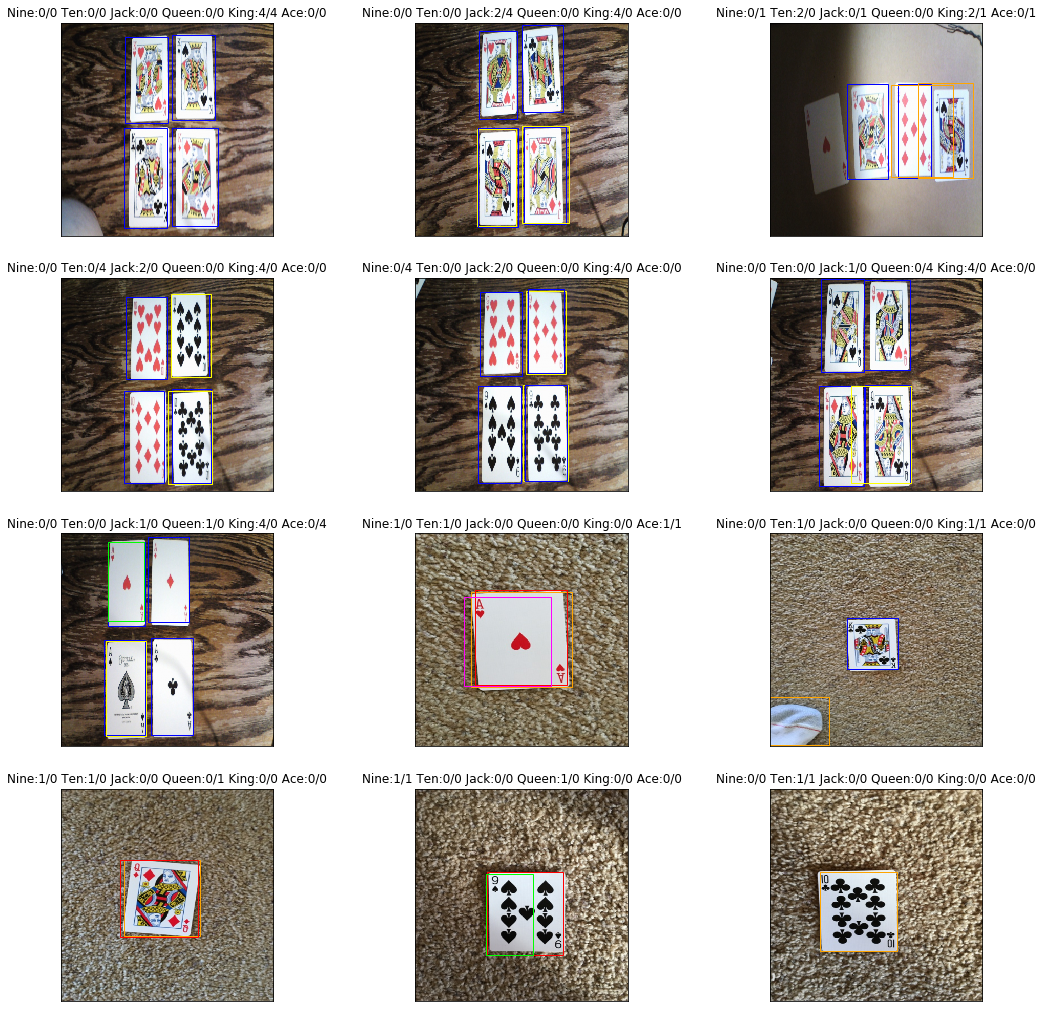

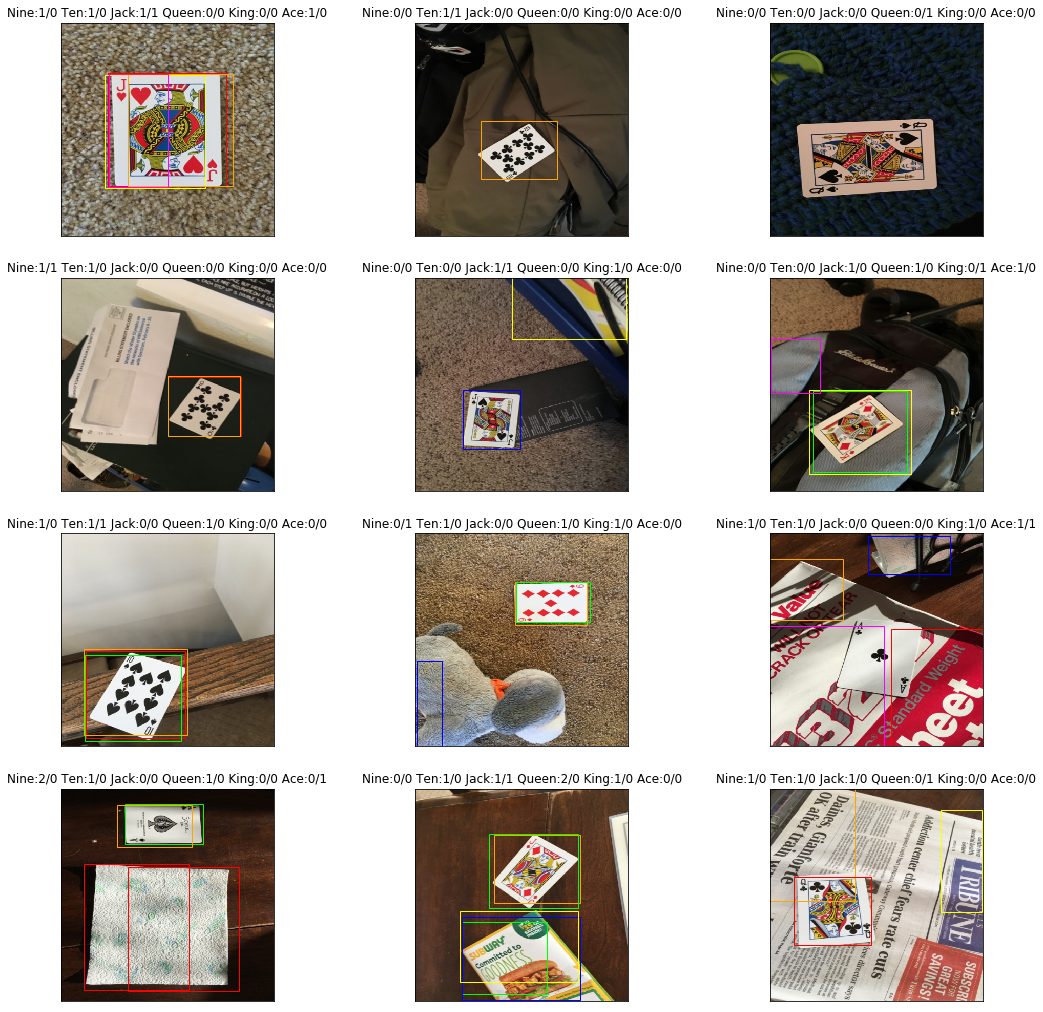

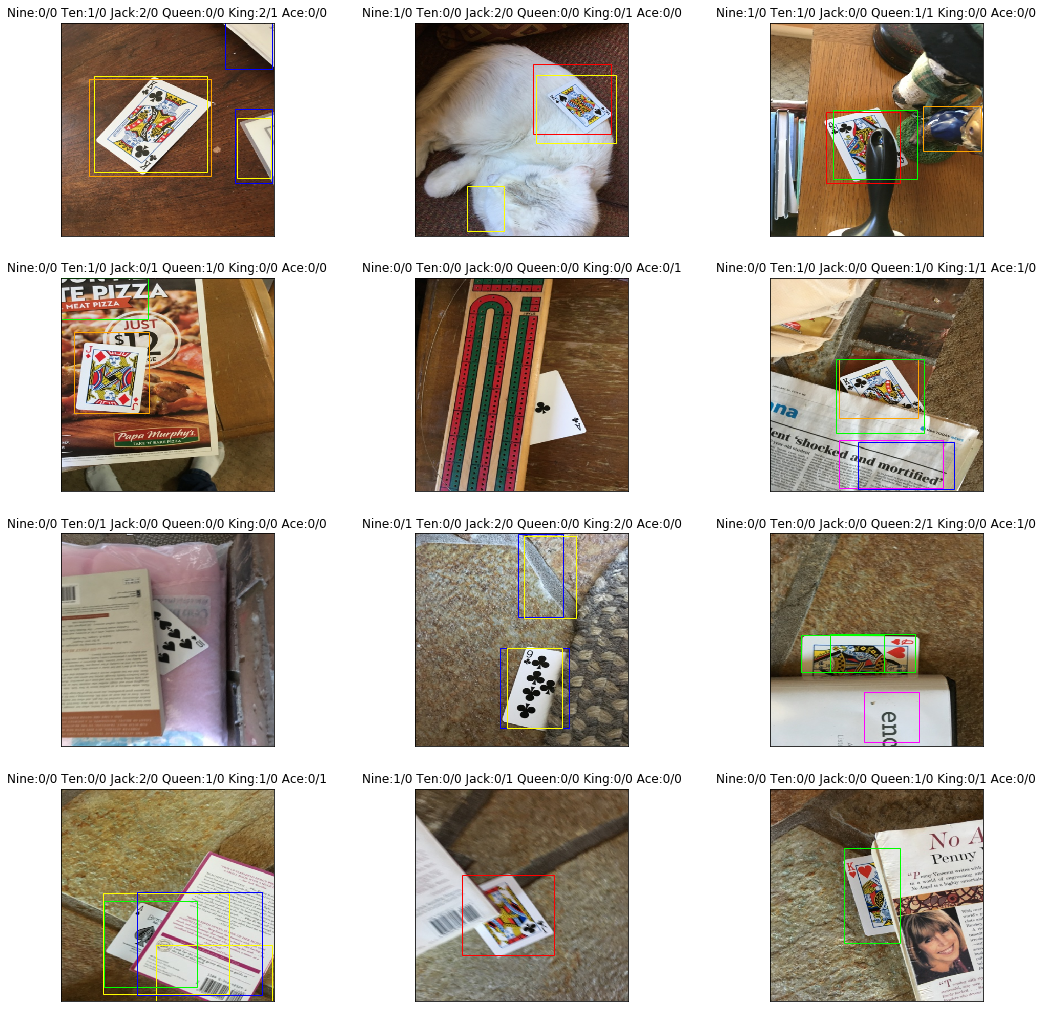

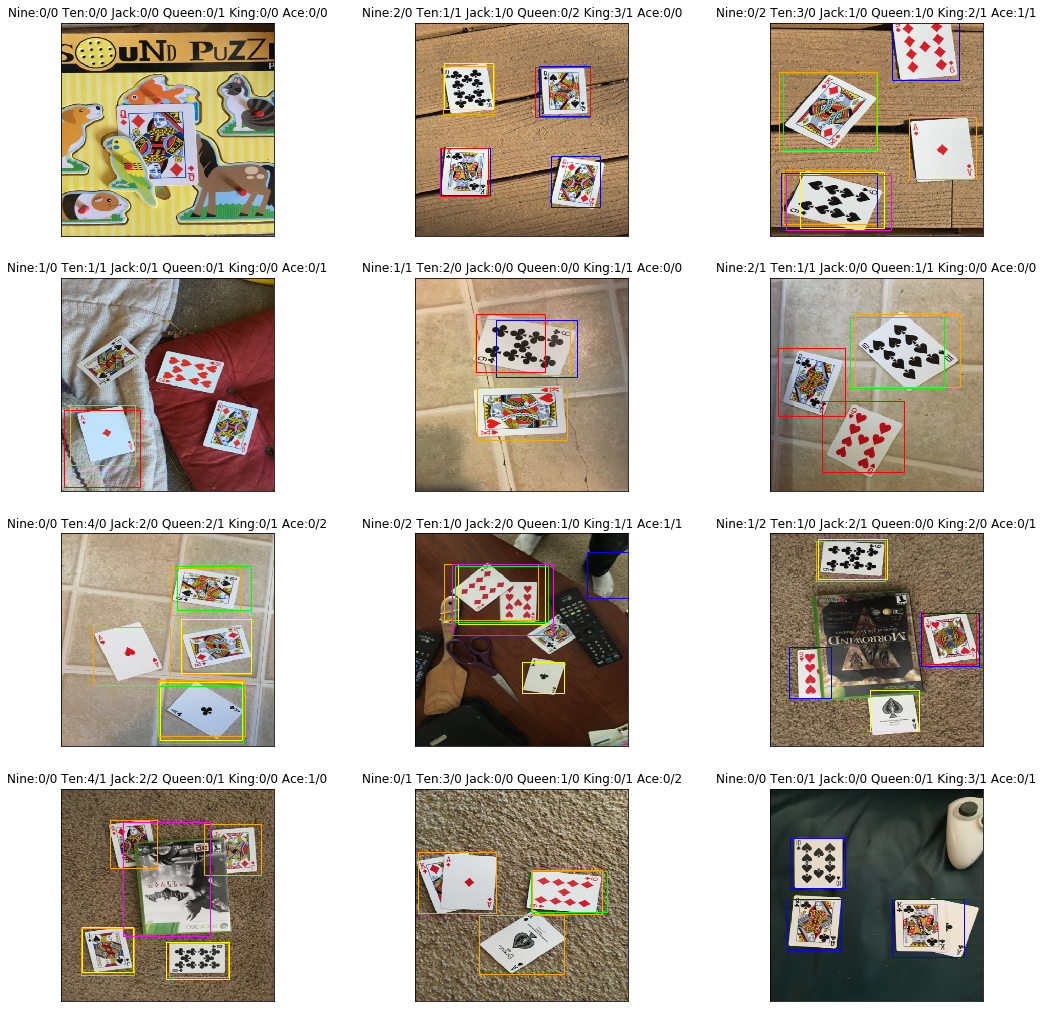

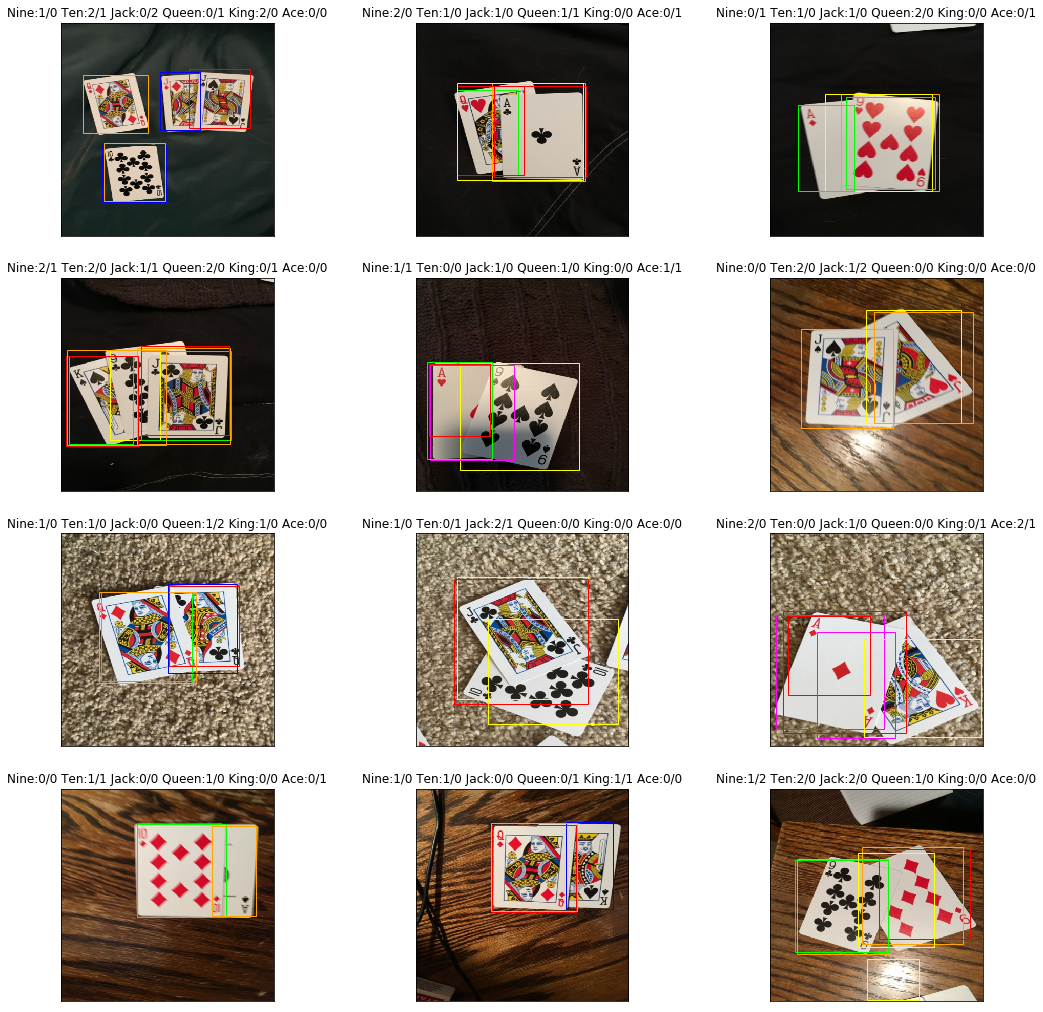

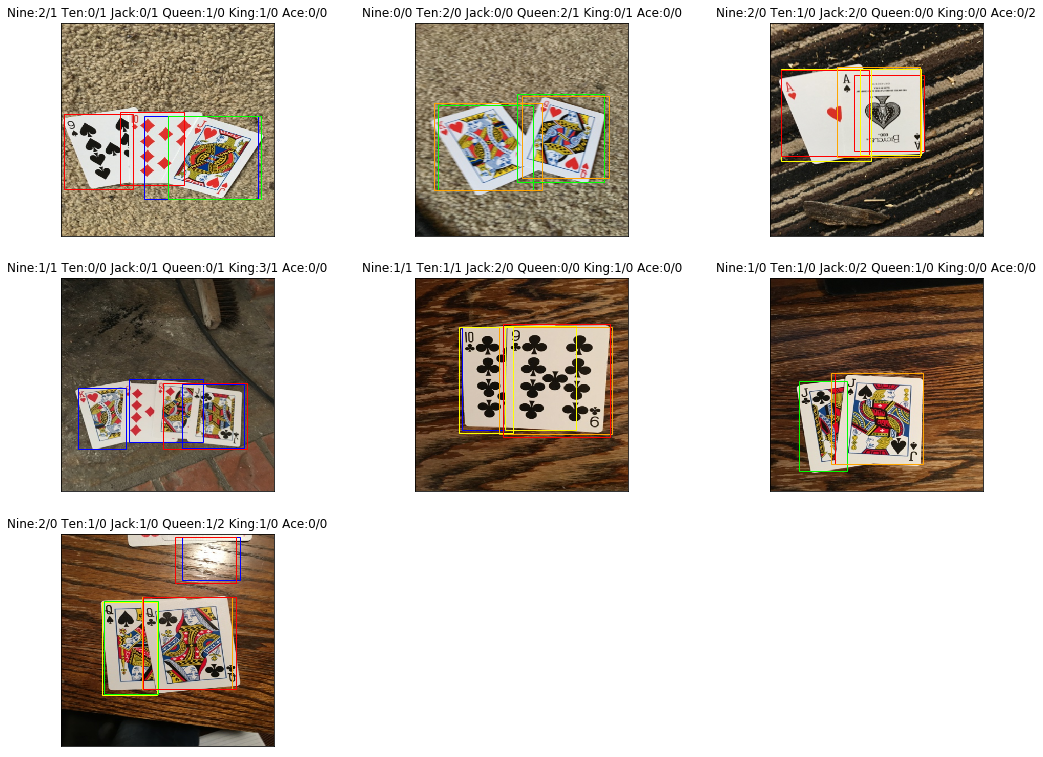

Test Total Loss: 1338.3 | Object Loss: 128.4, XY Loss: 12.7, WH Loss: 865.8, Class Loss: 331.4



In [23]:
loss = test(10)

In [ ]:
anaylse()